In [13]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE



In [14]:
(X,Y), (X_val,Y_val), axes = load_training_data('/data/u934/service_imagerie/v_kapoor/CurieTrainingDatasets/Drosophilla/BorialisSiS2Train25.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 11520
number of validation images:	 1280
image size (3D):		 (16, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


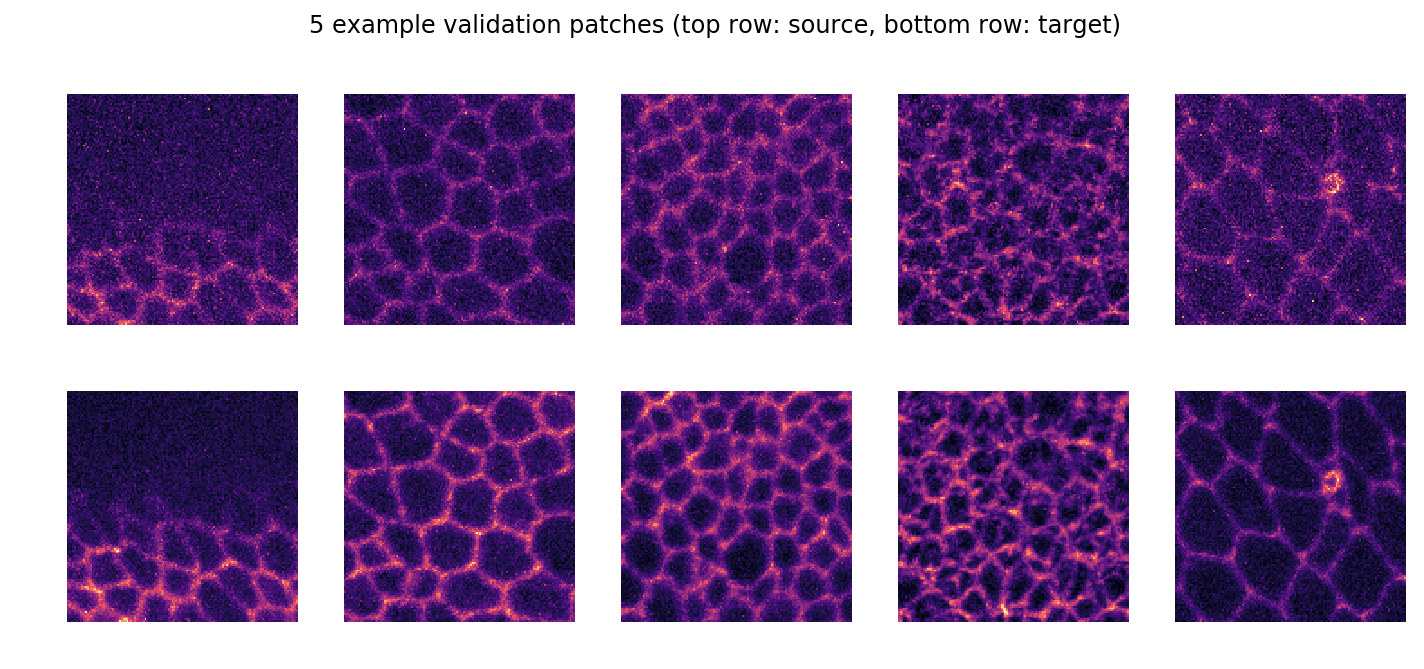

In [15]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [16]:
config = Config(axes, n_channel_in, n_channel_out, unet_n_depth=4,train_epochs= 50,train_steps_per_epoch = 400, train_batch_size = 16, train_reduce_lr={'patience': 5, 'factor': 0.5})
print(config)
vars(config)

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=50, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 5}, train_steps_per_epoch=400, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=4, unet_n_first=32, unet_residual=True)


{'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 3,
 'probabilistic': False,
 'train_batch_size': 16,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 50,
 'train_learning_rate': 0.0004,
 'train_loss': 'mae',
 'train_reduce_lr': {'factor': 0.5, 'patience': 5},
 'train_steps_per_epoch': 400,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 4,
 'unet_n_first': 32,
 'unet_residual': True}

In [17]:
model = CARE(config, 'BorialisS1S2FlorisMidNoiseModel25realimages', basedir='/data/u934/service_imagerie/v_kapoor/CurieDeepLearningModels')

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/models/care_standard.py:99: UserWarning: output path for model already exists, files may be overwritten: /data/u934/service_imagerie/v_kapoor/CurieDeepLearningModels/BorialisS1S2FlorisMidNoiseModel25realimages
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [ ]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/50
400/400 [==============================] - 3052s 8s/step - loss: 0.0592 - mse: 0.0076 - mae: 0.0592 - val_loss: 0.0519 - val_mse: 0.0055 - val_mae: 0.0519
Epoch 2/50
400/400 [==============================] - 3053s 8s/step - loss: 0.0505 - mse: 0.0053 - mae: 0.0505 - val_loss: 0.0494 - val_mse: 0.0051 - val_mae: 0.0494
Epoch 3/50
400/400 [==============================] - 3049s 8s/step - loss: 0.0488 - mse: 0.0050 - mae: 0.0488 - val_loss: 0.0482 - val_mse: 0.0050 - val_mae: 0.0482
Epoch 4/50
400/400 [==============================] - 3049s 8s/step - loss: 0.0486 - mse: 0.0050 - mae: 0.0486 - val_loss: 0.0476 - val_mse: 0.0048 - val_mae: 0.0476
Epoch 5/50
400/400 [==============================] - 3047s 8s/step - loss: 0.0478 - mse: 0.0048 - mae: 0.0478 - val_loss: 0.0476 - val_mse: 0.0049 - val_mae: 0.0476
Epoch 6/50
400/400 [==============================] - 3046s 8s/step - loss: 0.0483 - mse: 0.0050 - mae: 0.0483 - val_loss: 0.0477 - val_mse: 0.0048 - val_mae: 0.0477
Epoc

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

In [ ]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [ ]:
model.export_TF()